In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import h5py

In [2]:
x_train_original = np.array(h5py.File('train_catvnoncat.h5', "r")['train_set_x'])
y_train_original = np.array(h5py.File('train_catvnoncat.h5', "r")['train_set_y'])

x_test_original = np.array(h5py.File('test_catvnoncat.h5', "r")['test_set_x'])
y_test_original = np.array(h5py.File('test_catvnoncat.h5', "r")['test_set_y'])

In [3]:
num_pic_train=x_train_original.shape[0]
quality_pic_train=x_train_original.shape[1]

num_pic_test=x_test_original.shape[0]
quality_pic_test=x_test_original.shape[1]

In [4]:
x_train=np.zeros(((quality_pic_train**2)*3,num_pic_train))
x_test=np.zeros(((quality_pic_test**2)*3,num_pic_test))

for i in range(num_pic_train):x_train[:,i]=x_train_original[i,:,:,:].reshape(1,-1)
for i in range(num_pic_test): x_test[:,i]=x_test_original[i,:,:,:].reshape(1,-1)   

pictire 17 is a non-cat picture


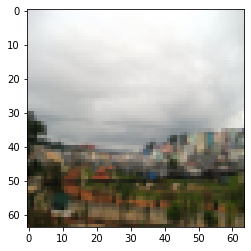

In [5]:
index=17;
plt.imshow(x_train_original[index])
if y_train_original[index]==1:
    string='cat'
else:
    string="non-cat"       
print(f"pictire {index} is a "+string+" picture") 

In [6]:
def feature_scaling(x):
    #x input array with shape (n,m) n:number of features m:number of training examples
    sigma=np.std(x,axis=1,keepdims=True)
    mu=np.mean(x,axis=1,keepdims=True)
    x_scaled=(x-mu)/sigma
    return mu,sigma,x_scaled

In [7]:
def linear_activation_function(x,linear_activation):
        if linear_activation=="sigmoid":
            z=1/(1+np.exp(-x))
        elif linear_activation=="relu":
            z=np.maximum(0,x)
        elif linear_activation=="tanh":
            z=np.tanh(x)
        return z       
    

In [8]:
class neural_network:
    def __init__(self,num_layers,units,x,y,linear_activations):
        #num_layers: model parameter, number of layers without including the input layer, scalar
        #units: model parameter, number of units of each layer, 
        #                         the input layer size should not be included in the list. type:list
        #x: input with shape (n,m) n:number of features m:number of training examples
        #y: input with shape (m,) m:number of training examples

        self.num_layers=num_layers
        self.units=units #it does not include the input layer size
        self.parameters={}
        self.m=x.shape[1];self.n=x.shape[0] #m:number of training examples, n:number of features
        self.x=x
        self.y=np.expand_dims(y,axis=0)
        self.units_modified=copy.deepcopy(self.units)
        (self.units_modified).insert(0,self.n)
        self.linear_activations=linear_activations
        
        assert len(units)==num_layers, "wrong number of units"
        assert type(units)==list, "wrong type for parameter units"
        assert len(linear_activations)==num_layers,"wrong linear_activations list"
        assert linear_activations[-1]=='sigmoid' or linear_activations[-1]=='relu',\
         "wrong output layer activation function"
        
    
    def initialize_network(self):
        for i in range(1,self.num_layers+1):
            self.parameters['W'+str(i)]=np.random.randn(self.units_modified[i],self.units_modified[i-1])*0.01
            self.parameters['b'+str(i)]=np.zeros((self.units[i-1],1))
        return self.parameters
  
   
        
    def propagation(self):
                 
        self.parameters['z1']=np.matmul(self.parameters['W1'],self.x)+self.parameters['b1']
        self.parameters['A1']=linear_activation_function(self.parameters['z1'],self.linear_activations[0])

        for i in range(2,self.num_layers+1):
            #print (i)
            self.parameters['z'+str(i)]=np.matmul(self.parameters['W'+str(i)],self.parameters['A'+str(i-1)])+self.parameters['b'+str(i)]
            self.parameters['A'+str(i)]=linear_activation_function(self.parameters['z'+str(i)],self.linear_activations[i-1])
        

        cost=-np.mean(self.y*np.log(self.parameters['A'+str(self.num_layers)])+
                                       (1-self.y)*np.log(1-self.parameters['A'+str(self.num_layers)]))
        
        
        self.parameters['dA'+str(self.num_layers)]=\
        -(np.divide(self.y, self.parameters['A'+str(self.num_layers)]) - np.divide(1 - self.y, 1 - self.parameters['A'+str(self.num_layers)]))
       
   
        for i in reversed(range(1,self.num_layers+1)):
            
            self.parameters['db'+str(i)],self.parameters['dw'+str(i)],self.parameters['dA'+str(i-1)]=\
            self.back_propagate(self.parameters['dA'+str(i)],i,self.linear_activations[i-1])                 
        return cost,self.parameters
 
 
    def back_propagate(self,dA,l,linear_activation):
        assert linear_activation=='relu' or linear_activation=='sigmoid' or linear_activation=='tanh', "wrong output activation function"
        if linear_activation=='relu':
            dz=dA
        elif linear_activation=='sigmoid' :
            z=self.parameters['z'+str(l)]
            s=1/(1+np.exp(-z))
            dz=dA*s*(1-s)
        else:
            z=self.parameters['z'+str(l)]
            s=1-(np.tanh(z))**2.0
            dz=dA*s       
        db=np.mean(dz,axis=0,keepdims=True)
        dA_prev=0
        dA_prev=np.matmul(np.transpose(self.parameters['W'+str(l)]),dz)
        if l!=1: dw=(1/self.m)*np.matmul(dz,np.transpose(self.parameters['A'+str(l-1)]))
        else:    dw=(1/self.m)*np.matmul(dz,np.transpose(self.x))
        
        return db,dw,dA_prev
    
    def optimize(self,n_iter,learning_rate):
        cost_history=list([])
        for i in range(n_iter):
            cost,params=self.propagation()
            for i in range(1,self.num_layers+1):
                self.parameters['W'+str(i)]=self.parameters['W'+str(i)]-learning_rate*self.parameters['dw'+str(i)]
                self.parameters['b'+str(i)]=self.parameters['b'+str(i)]-learning_rate*self.parameters['db'+str(i)]
            cost_history.append(cost)    
        return cost_history,params
    
 

In [9]:
mu,sigma,x_scaled=feature_scaling(x_train)
num_layers=4
units=[20, 7, 5, 1]
nn=neural_network(num_layers,units,x_scaled,y_train_original,['relu','relu','relu','sigmoid'])
nn.initialize_network()
learning_rate=0.1
n_iter=1000
cost_history,params=nn.optimize(n_iter,learning_rate)

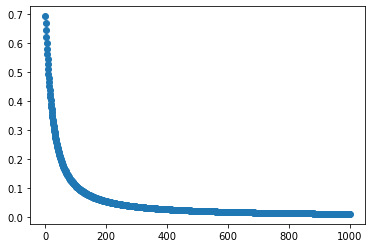

In [10]:
plt.scatter(np.linspace(1, len(cost_history), num=len(cost_history)),cost_history)


In [14]:
def predict(x,y,num_layers,units,parameters,linear_activation):
    A=x
    for i in range(1,num_layers+1):
        z=np.matmul(parameters['W'+str(i)],A)+parameters['b'+str(i)]
        A=linear_activation_function(z,linear_activation[i-1])
        

    return(A)     
        

In [15]:
parameters=params
output=predict(x_scaled,y_train_original,num_layers,units,params,['relu','relu','relu','sigmoid'])

In [16]:
y_predicted=(output>0.5).astype('int')
accuracy=(np.sum(y_predicted==y_train_original))*100/len(y_train_original) #accuracy on data training
print(accuracy)

100.0
